In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fname = 'train.csv'
data = pd.read_csv('preprocessed_' + fname, index_col='Id')
n_examples, n_features = data.shape

X, y = data.drop(columns=['SalePrice']), data['SalePrice']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

X.shape, y.shape

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape',
       'means_neigh', 'TotBath', 'KitchensRating', 'FireplacesRating',
       'GarageRating', 'HasBasement', 'SalePrice'],
      dtype='object')


In [5]:
# generate polynomial features

def generate_polynomial(df):
    lst = ['OverallQual', 'GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            poly_column_name = feat + ' ^ ' + str(degree)
            df.loc[:, poly_column_name] = df[feat]**degree
    return df

X = generate_polynomial(X)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# apply normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


# the same for test set
X_test = generate_polynomial(X_test)
X_test = scaler.transform(X_test)

features = X.columns.to_numpy()
X = scaler.transform(X)

(1460, 69) (1460,)


/home/paul/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Model Selection

In [6]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error"))
    return rmse

Linear models:

In [7]:
alpha_range = np.arange(0.01, 0.15, 0.01)

ridge = RidgeCV(alphas = alpha_range, scoring="neg_mean_squared_error").fit(X_train, y_train)
lasso = LassoCV(alphas = alpha_range).fit(X_train, y_train)
elastic_net = ElasticNetCV(alphas=alpha_range).fit(X_train, y_train)

print("RMSE for Ridge:      ", rmse_cv(ridge).mean())
print("RMSE for Lasso:      ", rmse_cv(lasso).mean())
print("RMSE for ElasticNet: ", rmse_cv(elastic_net).mean())


# print(ridge.score(X_train, y_train), lasso.score(X_train, y_train), elastic_net.score(X_train, y_train))
# print(ridge.score(X_test, y_test), lasso.score(X_test, y_test), elastic_net.score(X_test, y_test))
# print(ridge.alpha_, lasso.alpha_, elastic_net.alpha_, elastic_net.l1_ratio_)

/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022756432974503582, tolerance: 0.016938297685304308
  model = cd_fast.enet_coordinate_descent(


RMSE for Ridge:       0.1454593881956124


/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023057566562133758, tolerance: 0.0180024221282852
  model = cd_fast.enet_coordinate_descent(
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028744252186172048, tolerance: 0.018373848090999036
  model = cd_fast.enet_coordinate_descent(


RMSE for Lasso:       0.13956771912086507
RMSE for ElasticNet:  0.1399204286851495


XGBoost:

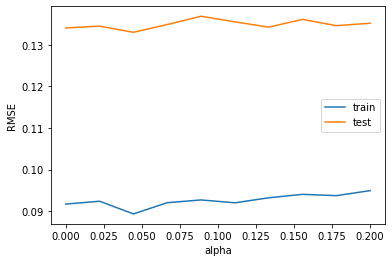

In [8]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 2, 
         'eta': 0.3, 
         'alpha': 1,
         'lambda': 0,
         'objective': 'reg:squarederror',
        'verbosity': 1}

num_round = 100
evallist = [(dtest, 'valid'), (dtrain, 'train')]

n_alpha = 10
alpha_range = np.linspace(0, 0.2, n_alpha)
scores_train = []
scores_test = []
for alpha in alpha_range: 
    param['alpha'] = alpha
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
    scores_train.append(np.sqrt(mean_squared_error(bst.predict(dtrain), y_train)))
    scores_test.append(np.sqrt(mean_squared_error(bst.predict(dtest), y_test)))

plt.plot(alpha_range, np.array(scores_train), label = "train")
plt.plot(alpha_range, np.array(scores_test), label = "test")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.legend();

In [9]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

def hyperParameterTuning():
    params = {
        "learning_rate" : [0.01, 0.1, 0.2, 0.3],
        "max_depth": [2, 3, 5, 10],
        "min_child_weight": [1, 3, 5],
        "subsample" : [1],
        'colsample_bytree': [0.5],
        "n_estimators" : [100, 200, 500],
        "objective": ['reg:squarederror'],  
    }
    
    gsearch = GridSearchCV(estimator=XGBRegressor(),
                          param_grid=params,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1,
                          verbose=1)
    gsearch.fit(X, y)
    return gsearch.best_params_

# hyperParameterTuning()

RMSE for final XGBoost regressor: 


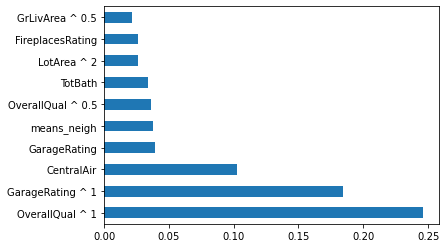

In [10]:
params = {'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 1}

print("RMSE for final XGBoost regressor: ")
xgbr = XGBRegressor(**params)
# xgbr.set_params(learning_rate=0.3)
xgbr.fit(X_train, y_train, verbose=0)
importance = pd.Series(xgbr.feature_importances_, index=features)
rmse_cv(xgbr).mean()

importance = importance.sort_values(ascending=False)
# display(importance)
importance = importance.head(10)
importance.plot(kind='barh');

Support Vector Regression

In [8]:
# hyperparameter tuning
from sklearn.svm import SVR

params = {
    "kernel": ["linear", "rbf"],
    "C": [0.5, 1, 2, 3],
    "epsilon": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_iter": [2000],
    "gamma": [0.001, 0.01, 0.1, 1, 10]}

gsearch = GridSearchCV(estimator= SVR(),
                       param_grid=params,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1,
                       verbose=1)
gsearch.fit(X, y)
gsearch.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished
/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'C': 1, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 2000}

In [9]:
# evaluating model
params = {'C': 1, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 5000}
svr = SVR(**params)

rmse_cv(svr).mean()

0.16086924336962966

Comparing performanse

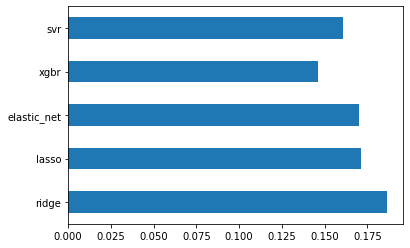

In [10]:
RMSE = pd.Series(index=["ridge", "lasso", "elastic_net", "xgbr", "svr"], dtype="float64")
for i, model in enumerate([ridge, lasso, elastic_net, xgbr, svr]):
    RMSE.iloc[i] = rmse_cv(model).mean()
    
RMSE.plot(kind="barh")

# Training ElasticNet

{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


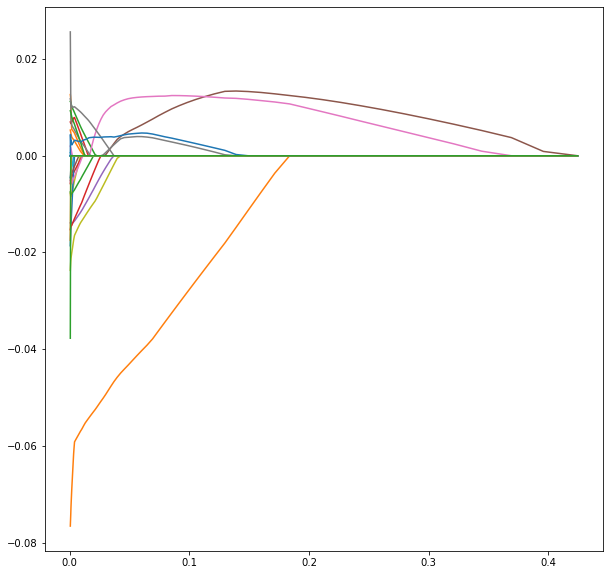

In [11]:
from sklearn.linear_model import ElasticNet, LinearRegression
model = ElasticNet(alpha=0.2, max_iter=10000).fit(X_train, y_train)

alphas, coefs, _ = model.path(X_train, y_train)
plt.figure(figsize=(10, 10))
for i in range(n_features):
    ax = plt.gca()
    ax.plot(alphas, coefs[i, :]);
    
# coefs.max()
# alphas.min(), alphas.max()
print(model.get_params())

In [12]:
# score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

def print_score(model):
    print(model)
    print('R^2 score on train = {:>10.2e}'.format(model.score(X_train, y_train)))
    print('R^2 score on test  = {:>10.2e}'.format(model.score(X_train, y_train)))

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    print('MSE on train       = {:>10.2e}'.format(mse))

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print('MSE on test        = {:>10.2e}'.format(mse))
    
print_score(ElasticNet(alpha=0.2, l1_ratio=0).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.1).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.2, l1_ratio=1).fit(X_train, y_train))

ElasticNet(alpha=0.2, l1_ratio=0)
R^2 score on train =   6.87e-01
R^2 score on test  =   6.87e-01
MSE on train       =   2.81e-02
MSE on test        =   2.88e-02


/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.063461401465187, tolerance: 0.009748603945682445
  model = cd_fast.enet_coordinate_descent(


In [13]:
# # choosing the best alpha
# from sklearn.model_selection import validation_curve
# alphas = np.linspace(0, 1, 50)
# train_scores, test_scores = validation_curve(ElasticNet(l1_ratio=0, max_iter=1000),
#                                              X_train, y_train,
#                                              param_name="alpha", 
#                                              param_range=alphas,
#                                              scoring=make_scorer(mean_squared_error))

In [14]:
# # train_scores = 
# # # train_scores
# # test_scores = )
# plt.figure(figsize=(10, 10))
# plt.plot(alphas, train_scores.mean(axis=1), label='train')
# plt.plot(alphas, test_scores.mean(axis=1), label='test')
# plt.legend()

# Training on entire dataset

In [11]:
X, y = data.drop(columns=['SalePrice']), data['SalePrice']
X = generate_polynomial(X)
print(X.columns)
scaler = StandardScaler().fit(X)

X = scaler.transform(X)

model = xgbr.fit(X, y)


Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape',
       'means_neigh', 'TotBath', 'KitchensRating', 'FireplacesRating',
       'GarageRating', 'HasBasement', 'OverallQual ^ 0.5', 'OverallQual ^ 1',
       'OverallQual ^ 2', 'OverallQual ^ 3', 'GrLivArea ^ 0.5',
       'GrLivArea ^ 1', 'GrLivArea ^ 2', 'GrLivArea ^ 3', 'GarageRating ^ 0.5',
       'GarageRating ^ 1', 'GarageRating ^ 2', 'GarageRating ^ 3',
       'YearBuilt ^ 0.5', 'YearBuilt ^ 1', 'YearBuilt ^ 2', 'YearBuilt ^ 3',
       'FireplacesRating ^ 0.5', 'FireplacesRating ^ 1',
       'FireplacesRatin

# Submitting

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fname = 'test.csv'
data = pd.read_csv('preprocessed_' + fname, index_col='Id')
n_examples, n_features = data.shape
X=data
print(X.shape)

def generate_polynomial(data):
    lst = ['OverallQual','GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            data[feat + ' ^ ' + str(degree)] = data[feat]**degree
    return data
X = generate_polynomial(X)
print(X.columns)

X = X.fillna(0)
# print(pd.isna(X).sum().sort_values())

X = scaler.transform(X)
y_pred = model.predict(X)
ser = pd.Series(np.exp(y_pred), index=data.index)
ser = ser.rename("SalePrice")
ser.to_csv('subm.csv')

(1459, 33)
Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape',
       'means_neigh', 'TotBath', 'KitchensRating', 'FireplacesRating',
       'GarageRating', 'HasBasement', 'OverallQual ^ 0.5', 'OverallQual ^ 1',
       'OverallQual ^ 2', 'OverallQual ^ 3', 'GrLivArea ^ 0.5',
       'GrLivArea ^ 1', 'GrLivArea ^ 2', 'GrLivArea ^ 3', 'GarageRating ^ 0.5',
       'GarageRating ^ 1', 'GarageRating ^ 2', 'GarageRating ^ 3',
       'YearBuilt ^ 0.5', 'YearBuilt ^ 1', 'YearBuilt ^ 2', 'YearBuilt ^ 3',
       'FireplacesRating ^ 0.5', 'FireplacesRating ^ 1',
       'Fire